In [22]:
import os
import requests
import h3
import geopy.distance
import geopy.point

import pandas as pd
import numpy as np

from dotenv import load_dotenv


load_dotenv()

True

In [23]:
# Fix a seed for sampling and preparation
seed = 42
sample_size = 10

cols = [
    'landmark_id', 'landmark_name', 'asciiname', 'alternatenames', 'landmark_latitude', 'landmark_longitude',
    'feature_class', 'landmark_feature_code', 'landmark_country_code', 'cc2', 'admin1_code',
    'admin2_code', 'admin3_code', 'admin4_code', 'landmark_population', 'elevation',
    'dem', 'timezone', 'modification_date'
]

# Load the data
df = pd.read_csv(
    '/Users/kaimoltzen/Downloads/cities15000.txt',
    sep='\t',
    header=None,
    names=cols,
    usecols=['landmark_id', 'landmark_name', 'landmark_latitude', 'landmark_longitude', 'landmark_feature_code', 'landmark_population', 'landmark_country_code'],
    low_memory=False,
    encoding='utf-8'
)

# Only US cities
df = df[df['landmark_country_code'] == 'US']

# Sample x rows
sample = df.sample(sample_size, random_state=seed)
head = sample.head(10)
# print the head of the sample and make sure all columns are printed
pd.set_option('display.max_columns', None)
sample

,geonameid,name,latitude,longitude,feature_code,country_code,population
26754,4745272,Baileys Crossroads,38.85039,-77.12970,PPL,US,23643
27996,5253352,Fond du Lac,43.77500,-88.43883,PPLA2,US,42933
26445,4529987,Bartlesville,36.74731,-95.98082,PPLA2,US,36595
28338,5378538,Oakland,37.80437,-122.27080,PPLA2,US,419267
25834,4165565,Naples,26.14234,-81.79596,PPLA2,US,21512
28266,5364199,Ladera Ranch,33.57086,-117.63561,PPL,US,22980
28649,5656882,Helena,46.59271,-112.03611,PPLA,US,32091
27445,5055787,Kirksville,40.19475,-92.58325,PPLA2,US,17520
28202,5344994,East Los Angeles,34.02390,-118.17202,PPL,US,126496
27648,5118226,Garden City,40.72677,-73.63430,PPL,US,22612


In [24]:
geospatial_prep_with_bearing = {
    'north': 0,
    'northeast': 45,
    'east': 90,
    'southeast': 135,
    'south': 180,
    'southwest': 225,
    'west': 270,
    'northwest': 315,
    'between': None,
    'near': None
}

In [25]:
# Extend the dataframe with geospatial prepositions, bearing, distance, and H3 cell resolution
rng = np.random.default_rng(seed)
# 1. randomly choose a geospatial preposition from the dictionary and add it in a new column
preps = list(geospatial_prep_with_bearing.keys())
sample["geospatial_prep"] = rng.choice(preps, size=sample_size)

# 2. Choose the corresponding bearing from the dictionary and add it in a new column. For near, choose a random number between 0 and 360 as bearing. For between, use the GeoNames API to get a city >15k population  nearby
sample["bearing"] = sample["geospatial_prep"].map(geospatial_prep_with_bearing)
sample["bearing"] = sample.apply(
    lambda x: rng.integers(0, 361) if x["geospatial_prep"] == "near" else x["bearing"],
    axis=1
)

def get_nearby_city(latitude, longitude, population):
    response = requests.get(
        f"http://api.geonames.org/findNearbyPlaceNameJSON?lat={latitude}&lng={longitude}&cities=cities15000&radius={population/1000}&maxRows=10&username={os.getenv("GEONAMES_USERNAME")}"
    )
    if response.status_code == 200:
        data = response.json()
        if data['geonames']:
            nearby_city = data['geonames'][1] if len(data['geonames']) > 1 else None # 0 is the same city
            return nearby_city
    return None

sample["between_object"] = sample.apply(
    lambda x: get_nearby_city(x["latitude"], x["longitude"], x["population"]) if x["geospatial_prep"] == "between" else None,
    axis=1
)

# 3. # For directions: Distance is sampled from a log-normal distribution with mean log(population/5) and std 1
sample["distance_to_landmark"] = sample.apply(
    lambda x: rng.lognormal(mean=np.log(x["population"] / 3), sigma=1) if x["geospatial_prep"] != "between" else None,
    axis=1
)

# 4. Generate the target location description
def generate_target_location_description(row):
    geospatial_prep = row['geospatial_prep']
    name = row['landmark_name']
    if geospatial_prep == "between":
        return f"{geospatial_prep} {name} and {row['between_object']['landmark_name']}"
    elif geospatial_prep == "near":
        return f"{geospatial_prep} {name}"
    else:
        return f"{round(row['distance_to_landmark'] / 1000, 1)} km {geospatial_prep} of {name}"

sample['target_location_description'] = sample.apply(generate_target_location_description, axis=1)
sample

,geonameid,name,latitude,longitude,feature_code,country_code,population,geospatial_prep,bearing,between_object,distance,target_location_description
26754,4745272,Baileys Crossroads,38.85039,-77.12970,PPL,US,23643,north,0.0,None,1285.888178,1.3 km north of Baileys Crossroads
27996,5253352,Fond du Lac,43.77500,-88.43883,PPLA2,US,42933,northwest,315.0,None,9757.568612,9.8 km northwest of Fond du Lac
26445,4529987,Bartlesville,36.74731,-95.98082,PPLA2,US,36595,west,270.0,None,5334.691803,5.3 km west of Bartlesville
28338,5378538,Oakland,37.80437,-122.27080,PPLA2,US,419267,south,180.0,None,82456.334839,82.5 km south of Oakland
25834,4165565,Naples,26.14234,-81.79596,PPLA2,US,21512,south,180.0,None,1833.321005,1.8 km south of Naples
28266,5364199,Ladera Ranch,33.57086,-117.63561,PPL,US,22980,between,NaN,"{'adminCode1': 'CA', 'lng': '-117.672', 'dista...",NaN,between Ladera Ranch and Mission Viejo
28649,5656882,Helena,46.59271,-112.03611,PPLA,US,32091,north,0.0,None,15464.323781,15.5 km north of Helena
27445,5055787,Kirksville,40.19475,-92.58325,PPLA2,US,17520,west,270.0,None,7627.019261,7.6 km west of Kirksville
28202,5344994,East Los Angeles,34.02390,-118.17202,PPL,US,126496,east,90.0,None,27026.110986,27.0 km east of East Los Angeles
27648,5118226,Garden City,40.72677,-73.63430,PPL,US,22612,north,0.0,None,13961.227641,14.0 km north of Garden City


In [26]:
sample["target_center"] = sample.apply(
    lambda x: geopy.distance.distance(kilometers=x["distance_to_landmark"]/1000).destination(
        (x["landmark_latitude"], x["landmark_longitude"]),
        x["bearing"]
    )if x["geospatial_prep"] != "between" else geopy.point.Point(
        latitude=(float(x["between_object"]["lat"]) + float(x["landmark_latitude"])) / 2,
        longitude=(float(x["between_object"]["lng"]) + float(x["landmark_longitude"])) / 2,
    ),
    axis=1
)
sample

,geonameid,name,latitude,longitude,feature_code,country_code,population,geospatial_prep,bearing,between_object,distance,target_location_description,target_center
26754,4745272,Baileys Crossroads,38.85039,-77.12970,PPL,US,23643,north,0.0,None,1285.888178,1.3 km north of Baileys Crossroads,"38 51m 43.1037s N, 77 7m 46.92s W"
27996,5253352,Fond du Lac,43.77500,-88.43883,PPLA2,US,42933,northwest,315.0,None,9757.568612,9.8 km northwest of Fond du Lac,"43 50m 13.4379s N, 88 31m 28.6298s W"
26445,4529987,Bartlesville,36.74731,-95.98082,PPLA2,US,36595,west,270.0,None,5334.691803,5.3 km west of Bartlesville,"36 44m 50.262s N, 96 2m 25.9994s W"
28338,5378538,Oakland,37.80437,-122.27080,PPLA2,US,419267,south,180.0,None,82456.334839,82.5 km south of Oakland,"37 3m 41.1298s N, 122 16m 14.88s W"
25834,4165565,Naples,26.14234,-81.79596,PPLA2,US,21512,south,180.0,None,1833.321005,1.8 km south of Naples,"26 7m 32.8523s N, 81 47m 45.456s W"
28266,5364199,Ladera Ranch,33.57086,-117.63561,PPL,US,22980,between,NaN,"{'adminCode1': 'CA', 'lng': '-117.672', 'dista...",NaN,between Ladera Ranch and Mission Viejo,"33 35m 7.584s N, 117 39m 13.698s W"
28649,5656882,Helena,46.59271,-112.03611,PPLA,US,32091,north,0.0,None,15464.323781,15.5 km north of Helena,"46 43m 54.5606s N, 112 2m 9.996s W"
27445,5055787,Kirksville,40.19475,-92.58325,PPLA2,US,17520,west,270.0,None,7627.019261,7.6 km west of Kirksville,"40 11m 40.9753s N, 92 40m 22.1546s W"
28202,5344994,East Los Angeles,34.02390,-118.17202,PPL,US,126496,east,90.0,None,27026.110986,27.0 km east of East Los Angeles,"34 1m 24.7867s N, 117 52m 45.841s W"
27648,5118226,Garden City,40.72677,-73.63430,PPL,US,22612,north,0.0,None,13961.227641,14.0 km north of Garden City,"40 51m 8.96534s N, 73 38m 3.48s W"


In [27]:
# Randomly choose a H3 cell resolution between 6 and 8 to determine the size of the area
sample["target_h3_resolution"] = rng.integers(6, 9, size=sample_size)
sample["target_cell"] = sample.apply(
    lambda x: h3.latlng_to_cell(lat=x["target_center"].latitude,
                                lng=x["target_center"].longitude,
                                res=x["target_h3_resolution"]),
    axis=1
)
sample["target_area"] = sample.apply(
    lambda x: h3.cell_area(x["target_cell"], unit="m^2"),
    axis=1
)
sample

,geonameid,name,latitude,longitude,feature_code,country_code,population,geospatial_prep,bearing,between_object,distance,target_location_description,target_center,h3_resolution,target_cell,target_area
26754,4745272,Baileys Crossroads,38.85039,-77.12970,PPL,US,23643,north,0.0,None,1285.888178,1.3 km north of Baileys Crossroads,"38 51m 43.1037s N, 77 7m 46.92s W",7,872aa84c8ffffff,5.009619e+06
27996,5253352,Fond du Lac,43.77500,-88.43883,PPLA2,US,42933,northwest,315.0,None,9757.568612,9.8 km northwest of Fond du Lac,"43 50m 13.4379s N, 88 31m 28.6298s W",6,86275c367ffffff,3.755665e+07
26445,4529987,Bartlesville,36.74731,-95.98082,PPLA2,US,36595,west,270.0,None,5334.691803,5.3 km west of Bartlesville,"36 44m 50.262s N, 96 2m 25.9994s W",6,8626ee157ffffff,3.866924e+07
28338,5378538,Oakland,37.80437,-122.27080,PPLA2,US,419267,south,180.0,None,82456.334839,82.5 km south of Oakland,"37 3m 41.1298s N, 122 16m 14.88s W",5,85283417fffffff,2.652749e+08
25834,4165565,Naples,26.14234,-81.79596,PPLA2,US,21512,south,180.0,None,1833.321005,1.8 km south of Naples,"26 7m 32.8523s N, 81 47m 45.456s W",5,854413c7fffffff,2.333873e+08
28266,5364199,Ladera Ranch,33.57086,-117.63561,PPL,US,22980,between,NaN,"{'adminCode1': 'CA', 'lng': '-117.672', 'dista...",NaN,between Ladera Ranch and Mission Viejo,"33 35m 7.584s N, 117 39m 13.698s W",7,8729a5492ffffff,5.811146e+06
28649,5656882,Helena,46.59271,-112.03611,PPLA,US,32091,north,0.0,None,15464.323781,15.5 km north of Helena,"46 43m 54.5606s N, 112 2m 9.996s W",8,882792756dfffff,7.022935e+05
27445,5055787,Kirksville,40.19475,-92.58325,PPLA2,US,17520,west,270.0,None,7627.019261,7.6 km west of Kirksville,"40 11m 40.9753s N, 92 40m 22.1546s W",5,85267223fffffff,2.509962e+08
28202,5344994,East Los Angeles,34.02390,-118.17202,PPL,US,126496,east,90.0,None,27026.110986,27.0 km east of East Los Angeles,"34 1m 24.7867s N, 117 52m 45.841s W",8,8829a0a5a1fffff,8.258415e+05
27648,5118226,Garden City,40.72677,-73.63430,PPL,US,22612,north,0.0,None,13961.227641,14.0 km north of Garden City,"40 51m 8.96534s N, 73 38m 3.48s W",8,882a101513fffff,7.423544e+05


In [28]:
# Randomly choose a natural disaster from the list
natural_disasters = ['storm', 'flood', 'landslide', 'wild fire']
sample["natural_disaster"] = rng.choice(natural_disasters, size=sample_size)
sample

,geonameid,name,latitude,longitude,feature_code,country_code,population,geospatial_prep,bearing,between_object,distance,target_location_description,target_center,h3_resolution,target_cell,target_area,natural_disaster
26754,4745272,Baileys Crossroads,38.85039,-77.12970,PPL,US,23643,north,0.0,None,1285.888178,1.3 km north of Baileys Crossroads,"38 51m 43.1037s N, 77 7m 46.92s W",7,872aa84c8ffffff,5.009619e+06,flood
27996,5253352,Fond du Lac,43.77500,-88.43883,PPLA2,US,42933,northwest,315.0,None,9757.568612,9.8 km northwest of Fond du Lac,"43 50m 13.4379s N, 88 31m 28.6298s W",6,86275c367ffffff,3.755665e+07,landslide
26445,4529987,Bartlesville,36.74731,-95.98082,PPLA2,US,36595,west,270.0,None,5334.691803,5.3 km west of Bartlesville,"36 44m 50.262s N, 96 2m 25.9994s W",6,8626ee157ffffff,3.866924e+07,storm
28338,5378538,Oakland,37.80437,-122.27080,PPLA2,US,419267,south,180.0,None,82456.334839,82.5 km south of Oakland,"37 3m 41.1298s N, 122 16m 14.88s W",5,85283417fffffff,2.652749e+08,wild fire
25834,4165565,Naples,26.14234,-81.79596,PPLA2,US,21512,south,180.0,None,1833.321005,1.8 km south of Naples,"26 7m 32.8523s N, 81 47m 45.456s W",5,854413c7fffffff,2.333873e+08,landslide
28266,5364199,Ladera Ranch,33.57086,-117.63561,PPL,US,22980,between,NaN,"{'adminCode1': 'CA', 'lng': '-117.672', 'dista...",NaN,between Ladera Ranch and Mission Viejo,"33 35m 7.584s N, 117 39m 13.698s W",7,8729a5492ffffff,5.811146e+06,flood
28649,5656882,Helena,46.59271,-112.03611,PPLA,US,32091,north,0.0,None,15464.323781,15.5 km north of Helena,"46 43m 54.5606s N, 112 2m 9.996s W",8,882792756dfffff,7.022935e+05,storm
27445,5055787,Kirksville,40.19475,-92.58325,PPLA2,US,17520,west,270.0,None,7627.019261,7.6 km west of Kirksville,"40 11m 40.9753s N, 92 40m 22.1546s W",5,85267223fffffff,2.509962e+08,wild fire
28202,5344994,East Los Angeles,34.02390,-118.17202,PPL,US,126496,east,90.0,None,27026.110986,27.0 km east of East Los Angeles,"34 1m 24.7867s N, 117 52m 45.841s W",8,8829a0a5a1fffff,8.258415e+05,flood
27648,5118226,Garden City,40.72677,-73.63430,PPL,US,22612,north,0.0,None,13961.227641,14.0 km north of Garden City,"40 51m 8.96534s N, 73 38m 3.48s W",8,882a101513fffff,7.423544e+05,wild fire


In [29]:
# Invoke VLM to generate description of the area
from openai import OpenAI
import io
import base64
import math
import matplotlib.pyplot as plt
import contextily as cx
from pyproj import Transformer, CRS

# API configuration
api_key = os.getenv("CHATAI_API_KEY")
base_url = "https://chat-ai.academiccloud.de/v1"
model = "gemma-3-27b-it"

client = OpenAI(
    api_key=api_key,
    base_url=base_url,
)


def generate_map_image(
        lat,
        lon,
        natural_disaster,
        map_size_meters=1000,
        image_size_pixels=1024,
        tile_provider=cx.providers.OpenStreetMap.Mapnik
):
    """
    Generates a base64-encoded PNG image of a map centered at the given latitude and longitude,
    approximating the bounding box from meters to lat/lon degrees at that center point.

    Steps:
      1. Convert desired map size (meters) to approximate offsets in latitude/longitude degrees.
         - 1 degree of latitude ~ 111.32 km
         - 1 degree of longitude ~ 111.32 km * cos(latitude)
      2. Build lat/lon bounding box.
      3. Transform corners to EPSG:3857 and set axis bounds for contextily.
      4. Return the map as a base64-encoded PNG string.

    Parameters:
      lat (float): Latitude of the center point (WGS84).
      lon (float): Longitude of the center point (WGS84).
      natural_disaster (str): Type of natural disaster.
      map_size_meters (float): Desired side length of the map in meters.
      image_size_pixels (int): Output image width/height in pixels.
      tile_provider: Tile provider for the basemap.

    Returns:
      str: Base64-encoded PNG image of the map.
    """

    # Approximate meters per degree of latitude and longitude near this latitude
    # 1 deg latitude ~ 111.32 km
    # 1 deg longitude ~ 111.32 km * cos(latitude)
    meters_per_degree_lat = 111320.0  # approximate
    lat_radians = math.radians(lat)
    meters_per_degree_lon = 111320.0 * math.cos(lat_radians)

    # Convert the desired map size in meters to degrees of lat/lon
    d_lat = (map_size_meters / meters_per_degree_lat) / 2.0
    d_lon = (map_size_meters / meters_per_degree_lon) / 2.0

    # Build the bounding box in lat/lon
    lat_min = lat - d_lat
    lat_max = lat + d_lat
    lon_min = lon - d_lon
    lon_max = lon + d_lon

    # Prepare transformation from WGS84 (EPSG:4326) to Web Mercator (EPSG:3857)
    wgs84 = CRS.from_epsg(4326)
    web_merc = CRS.from_epsg(3857)
    transformer_to_web = Transformer.from_crs(wgs84, web_merc, always_xy=True)

    # Transform bounding box corners to EPSG:3857
    x_min, y_min = transformer_to_web.transform(lon_min, lat_min)
    x_max, y_max = transformer_to_web.transform(lon_max, lat_max)

    # Create figure
    dpi = 100
    fig, ax = plt.subplots(figsize=(image_size_pixels / dpi, image_size_pixels / dpi), dpi=dpi)

    # Set axes bounds in EPSG:3857
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.axis('off')

    # Add basemap (contextily automatically picks a zoom level)
    cx.add_basemap(ax, crs=web_merc.to_string(), source=tile_provider)

    # Save to memory
    buffer = io.BytesIO()
    plt.savefig(buffer, format='png', bbox_inches='tight', pad_inches=0)
    #plt.savefig('map.png', format='png', bbox_inches='tight', pad_inches=0)
    plt.close(fig)
    buffer.seek(0)

    # Encode image as base64
    image_base64 = base64.b64encode(buffer.read()).decode('utf-8')

    response = client.chat.completions.create(
    model=model,
    messages=[
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": f"Please create one concise description of this area which can be directly used in a news article about a {natural_disaster} in this area. Please only describe the area based on the provided map, not the natural disaster. Start with 'The area is...'",
                    },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/png;base64,{image_base64}",
                        },
                    },
                ],
            }
        ],
    )
    return response.choices[0].message.content

sample["target_area_description"] = sample.apply(
    lambda x: generate_map_image(lat=x["target_center"].latitude,
                                 lon=x["target_center"].longitude,
                                 natural_disaster=x["natural_disaster"],
                                 map_size_meters=2 * np.sqrt(x["target_area"])),
    axis=1
)

In [31]:
# Invoke LLM to generate report of the natural disaster
# World's largest independent news outlet, AP, instructs its journalists to write news articles of 300 - 500 words length: https://www.washingtonpost.com/lifestyle/style/new-ap-guidelines-keep-it-brief/2014/05/12/f220f902-d9ff-11e3-bda1-9b46b2066796_story.html
def generate_disaster_news_article(description, disaster, target_location_description):
    response = client.chat.completions.create(
        model=model,
        messages=[
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": f"Please provide an AP-style news article about a {disaster} which happened {target_location_description}. The article should be about 300 words long and explicitly include the location description '{target_location_description}'. The area where the {disaster} occurred is described as: {description}",
                    },
                ],
            }
        ],
    )
    return response.choices[0].message.content
sample["disaster_news_article"] = sample.apply(
    lambda x: generate_disaster_news_article(
        description=x["target_area_description"],
        disaster=x["natural_disaster"],
        target_location_description=x["target_location_description"]
    ),
    axis=1
)

In [32]:
sample

,geonameid,name,latitude,longitude,feature_code,country_code,population,geospatial_prep,bearing,between_object,distance,target_location_description,target_center,h3_resolution,target_cell,target_area,natural_disaster,target_area_description,disaster_report
26754,4745272,Baileys Crossroads,38.85039,-77.12970,PPL,US,23643,north,0.0,None,1285.888178,1.3 km north of Baileys Crossroads,"38 51m 43.1037s N, 77 7m 46.92s W",7,872aa84c8ffffff,5.009619e+06,flood,The area is a largely residential region in Ar...,## Flash Flooding Displaces Residents in Arlin...
27996,5253352,Fond du Lac,43.77500,-88.43883,PPLA2,US,42933,northwest,315.0,None,9757.568612,9.8 km northwest of Fond du Lac,"43 50m 13.4379s N, 88 31m 28.6298s W",6,86275c367ffffff,3.755665e+07,landslide,The area is a largely rural landscape in south...,## Landslide Disrupts Rural Wisconsin Area Nor...
26445,4529987,Bartlesville,36.74731,-95.98082,PPLA2,US,36595,west,270.0,None,5334.691803,5.3 km west of Bartlesville,"36 44m 50.262s N, 96 2m 25.9994s W",6,8626ee157ffffff,3.866924e+07,storm,The area is a largely rural expanse of farmlan...,## Severe Storm Causes Damage in Rural Washing...
28338,5378538,Oakland,37.80437,-122.27080,PPLA2,US,419267,south,180.0,None,82456.334839,82.5 km south of Oakland,"37 3m 41.1298s N, 122 16m 14.88s W",5,85283417fffffff,2.652749e+08,wild fire,The area is a largely undeveloped coastal regi...,## Wildfire Burns in Coastal Region 82.5 km So...
25834,4165565,Naples,26.14234,-81.79596,PPLA2,US,21512,south,180.0,None,1833.321005,1.8 km south of Naples,"26 7m 32.8523s N, 81 47m 45.456s W",5,854413c7fffffff,2.333873e+08,landslide,"The area is a mix of coastal wetlands, mangrov...","## Landslide Disrupts Traffic, Prompts Evacuat..."
28266,5364199,Ladera Ranch,33.57086,-117.63561,PPL,US,22980,between,NaN,"{'adminCode1': 'CA', 'lng': '-117.672', 'dista...",NaN,between Ladera Ranch and Mission Viejo,"33 35m 7.584s N, 117 39m 13.698s W",7,8729a5492ffffff,5.811146e+06,flood,The area is a suburban community centered arou...,"## Flash Flood Causes Road Closures, Evacuatio..."
28649,5656882,Helena,46.59271,-112.03611,PPLA,US,32091,north,0.0,None,15464.323781,15.5 km north of Helena,"46 43m 54.5606s N, 112 2m 9.996s W",8,882792756dfffff,7.022935e+05,storm,The area is a largely residential region compr...,## Severe Storm Damages Homes North of Helena\...
27445,5055787,Kirksville,40.19475,-92.58325,PPLA2,US,17520,west,270.0,None,7627.019261,7.6 km west of Kirksville,"40 11m 40.9753s N, 92 40m 22.1546s W",5,85267223fffffff,2.509962e+08,wild fire,The area is a mix of rural farmland and forest...,"## Wildfire Burns Near Kirksville, Missouri; E..."
28202,5344994,East Los Angeles,34.02390,-118.17202,PPL,US,126496,east,90.0,None,27026.110986,27.0 km east of East Los Angeles,"34 1m 24.7867s N, 117 52m 45.841s W",8,8829a0a5a1fffff,8.258415e+05,flood,The area is a largely residential community si...,"## Flash Floods Submerge Homes, Prompt Evacuat..."
27648,5118226,Garden City,40.72677,-73.63430,PPL,US,22612,north,0.0,None,13961.227641,14.0 km north of Garden City,"40 51m 8.96534s N, 73 38m 3.48s W",8,882a101513fffff,7.423544e+05,wild fire,The area is a densely populated residential zo...,## Wildfire Forces Evacuations Near Garden Cit...


In [34]:
# print the disaster_news_article for each row in the sample df
for index, row in sample.iterrows():
    print(f"Disaster Report for {row['landmark_name']} ({row['geospatial_prep']}):")
    print(row['disaster_news_article'])
    print("\n" + "="*80 + "\n")

Disaster Report for Baileys Crossroads (north):
## Flash Flooding Displaces Residents in Arlington County

**ARLINGTON, Va. (AP) —** Heavy rainfall overnight caused significant flash flooding in a residential area **1.3 km north of Baileys Crossroads**, displacing dozens of Arlington County residents and prompting emergency rescues early Tuesday.

The hardest-hit area, a largely residential region bisected by major roadways like US-50, SR-714 (Arlington Boulevard), and featuring a network of smaller streets, experienced rapid water level rises after a period of intense downpours. The flooding centered around North Callin Springs Road and extended from near Upton Hill to Bailey’s Crossroads.

Arlington County Fire Department responded to over 50 calls for assistance, including reports of flooded basements and stranded motorists. Fire officials confirmed they rescued at least 15 people from homes and vehicles, utilizing swift water rescue teams and inflatable boats. No injuries have been

In [1]:
sample["target_center"] = sample.apply(
    lambda x: x["target_center"].format_decimal(altitude=False),
    axis=1
)
sample

NameError: name 'sample' is not defined

In [37]:
# save df as json to this path: /Users/kaimoltzen
sample.to_json(
    '/Users/kaimoltzen/Downloads/georelating_dataset.json',
    orient='records',
    index=False
)

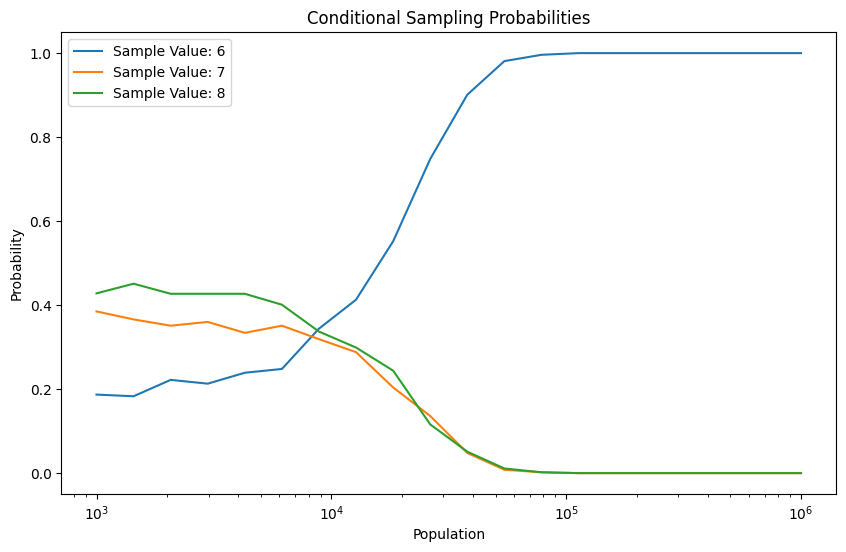

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def sample_conditional_integer(row):
    population = row["population"]
    x = np.array([6, 7, 8])
    logits = np.array([
        population / 1e6,
        0.8 - population / 1e4,
        1 - population / 1e4
    ])
    probabilities = np.exp(logits) / np.sum(np.exp(logits))
    return np.random.choice(x, p=probabilities)

# Define population values
population_values = np.logspace(3, 6, 20).astype(int)

# Simulate 1000 runs for each population value
sample_values = [6, 7, 8]
probabilities_over_population = np.zeros((len(population_values), len(sample_values)))

for i, population in enumerate(population_values):
    row = pd.Series({"population": population})
    samples = [sample_conditional_integer(row) for _ in range(1000)]
    for j, sample_value in enumerate(sample_values):
        probabilities_over_population[i, j] = samples.count(sample_value) / len(samples)

# Plot the results
plt.figure(figsize=(10, 6))
for j, sample_value in enumerate(sample_values):
    plt.plot(population_values, probabilities_over_population[:, j], label=f"Sample Value: {sample_value}")

plt.xscale("log")
plt.xlabel("Population")
plt.ylabel("Probability")
plt.title("Conditional Sampling Probabilities")
plt.legend()
plt.show()

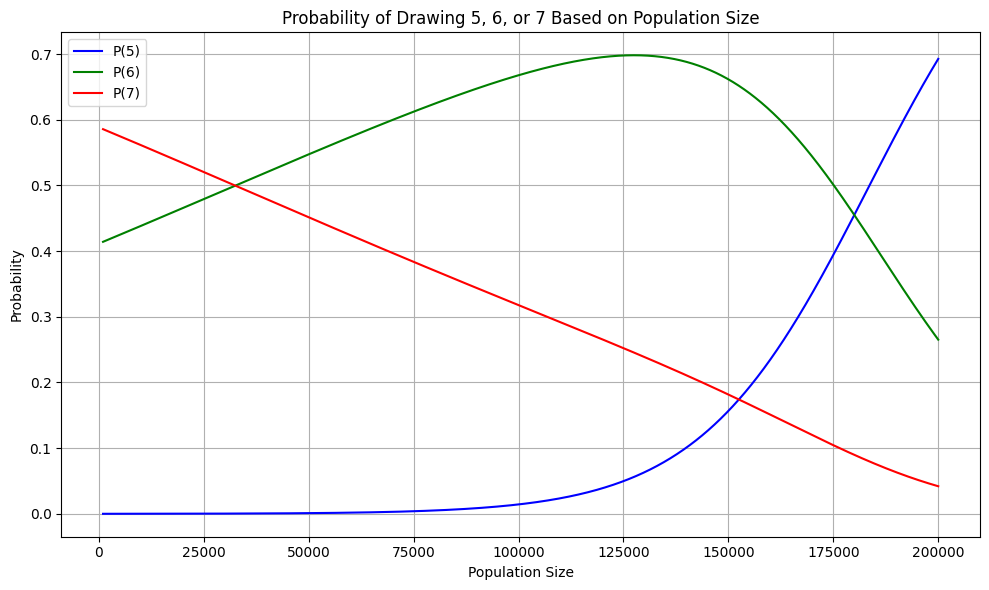

In [48]:
import numpy as np
import matplotlib.pyplot as plt

# Define the probability function
def get_probabilities(population):
    center_5, width_5 = 300_000, 100_000
    center_6, width_6 = 60_000, 100_000
    center_7, width_7 = 5_000, 100_000

    p5 = np.exp(-((population - center_5) / width_5) ** 2)
    p6 = np.exp(-((population - center_6) / width_6) ** 2)
    p7 = np.exp(-((population - center_7) / width_7) ** 2)

    total = p5 + p6 + p7
    return p5 / total, p6 / total, p7 / total

# Generate population range
pop_range = np.linspace(1_000, 200_000, 10000)
p5_vals, p6_vals, p7_vals = [], [], []

# Compute probabilities across the range
for pop in pop_range:
    p5, p6, p7 = get_probabilities(pop)
    p5_vals.append(p5)
    p6_vals.append(p6)
    p7_vals.append(p7)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(pop_range, p5_vals, label='P(5)', color='blue')
plt.plot(pop_range, p6_vals, label='P(6)', color='green')
plt.plot(pop_range, p7_vals, label='P(7)', color='red')
plt.xlabel('Population Size')
plt.ylabel('Probability')
plt.title('Probability of Drawing 5, 6, or 7 Based on Population Size')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [60]:
import geopandas as gpd
from shapely.geometry import Point

longitude = -9.37712129811443
latitude = 47.63183225041958

# 1. Load the land polygons (e.g., from a shapefile)
land_poly = gpd.read_file("/Users/kaimoltzen/Downloads/ne_10m_land")

# 2. Construct a point (using longitude, latitude)
location_point = gpd.GeoSeries([Point(longitude, latitude)], crs="EPSG:4326")

# 3. Perform a spatial join or use the “within” method
joined = gpd.sjoin(location_point.to_frame("geometry"), land_poly, predicate="within")

# If “joined” is empty, the point is likely over water; otherwise, it’s on land
if joined.empty:
    print("Point is on water.")
else:
    print("Point is on land.")

Point is on water.


In [88]:
# load the dataset from data_handler/georelating_dataset_20250512_us.json
import pandas as pd
df = pd.read_json(
    '../data/georelating_dataset_20250512_eu.json',
    orient='records'
)
df

,landmark_id,landmark_name,landmark_latitude,landmark_longitude,landmark_feature_code,landmark_country_code,landmark_population,geospatial_prep,bearing,between_object,distance_to_landmark,target_location_description,target_center,on_water,target_h3_resolution,target_cell,target_area,natural_disaster,target_area_description,disaster_news_article
0,2509408,Yaiza,28.95678,-13.76535,PPLA3,ES,8777,north,0.0,None,1001.390319,1.0 km north of Yaiza,"28.965814954461344, -13.76535",False,7,873469c62ffffff,5.854043e+06,landslide,"The area is a rural, hilly region in Yaiza, La...","## Landslide Blocks Roads, Prompts Evacuations..."
1,2940611,Buttenwiesen,48.60000,10.71667,PPLA4,DE,5750,northwest,315.0,None,3915.660592,3.9 km northwest of Buttenwiesen,"48.62489257210159, 10.679111647849208",False,6,861f8ca77ffffff,3.431837e+07,storm,The area is a largely rural landscape in Bavar...,## Severe Storm Causes Damage in Rural Bavaria...
2,2521485,Atarfe,37.22479,-3.68686,PPLA3,ES,15399,west,270.0,None,37825.626185,37.8 km west of Atarfe,"37.224023140349566, -4.1130663842951565",False,7,873919134ffffff,5.375983e+06,landslide,"The area is a sparsely populated, heavily fore...","## Landslide Blocks Highway West of Granada, E..."
3,257811,Mándra,38.06667,23.50000,PPLA3,GR,11327,south,180.0,None,1164.116288,1.2 km south of Mándra,"38.05618224282831, 23.5",False,6,861eda727ffffff,4.167206e+07,landslide,"The area is a hilly, sparsely populated region...","## Landslide Blocks Highways West of Athens, D..."
4,6534273,Alba Adriatica,42.83176,13.92590,PPLA3,IT,11165,south,180.0,None,1610.763343,1.6 km south of Alba Adriatica,"42.81726028596278, 13.9259",False,7,871e85745ffffff,5.499545e+06,flood,The area is a coastal strip along the Adriatic...,## Flash Flooding Causes Damage South of Alba ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,3087072,Rogoźno,52.75226,16.99049,PPLA3,PL,10859,north,0.0,None,5093.120085,5.1 km north of Rogoźno,"52.7980276771591, 16.99049",False,7,871f0b40affffff,4.633102e+06,flood,"The area is a largely rural, agricultural land...","## Floodwaters Subside, Assessment Underway in..."
1096,2879200,Leinburg,49.45167,11.31000,PPLA4,DE,6446,between,NaN,"{'adminCode1': '02', 'lng': '11.3573', 'distan...",NaN,between Leinburg and Altdorf bei Nürnberg,"49.418634999999995, 11.33365",False,7,871fabad5ffffff,4.851083e+06,storm,The area is a rural region in southwestern Ger...,## Severe Storm Causes Damage Between Leinburg...
1097,2830652,Spelle,52.36667,7.46667,PPLA4,DE,8327,northwest,315.0,None,2739.984300,2.7 km northwest of Spelle,"52.38407812943534, 7.438215038771758",False,7,871f16333ffffff,4.423394e+06,wild fire,The area is a largely rural landscape intersec...,"## Wildfire Contained Near Spelle, Investigati..."
1098,3086511,Rypin,53.06603,19.40941,PPLA2,PL,16589,north,0.0,None,1292.435285,1.3 km north of Rypin,"53.07764346844919, 19.40941",False,6,861f5605fffffff,3.242567e+07,storm,The area is a largely rural region in central ...,## Severe Storm Damages Rural Areas 1.3 km Nor...


In [89]:
import random
import numpy as np
import re

def parse_acres_string(acres_raw):
    """Parses a string like '1,500' or '1,000.5' by treating commas as thousands separators."""
    try:
        acres_str = acres_raw.replace(",", "")  # Remove thousands separators
        return float(acres_str)
    except ValueError:
        return None


# Example: df = pd.read_csv("your_file.csv")

# Initialize the new column
df["original_acres"] = np.nan

# Identify rows with numeric acres
rows_with_acres = []
for index, row in df.iterrows():
    match = re.search(r'\b(\d+)\s+acres\b', row["disaster_news_article"])
    if match:
        rows_with_acres.append(index)

# Randomly select half to modify
random.seed(42)
selected_indices = random.sample(rows_with_acres, len(rows_with_acres) // 2)

# Replace the acreage and track replacements
for index in rows_with_acres:
    article = df.at[index, "disaster_news_article"]
    match = re.search(r'\b([\d,\.]+)\s+acres\b', article)
    if match:
        acres_raw = match.group(1)
        original_acres = parse_acres_string(acres_raw)
        if original_acres is None:
            print(f"Could not parse acres value '{acres_raw}' in row {index}")
            continue
        if index in selected_indices:
            replaced_acres = int(original_acres * 10)
            # Replace the first occurrence
            updated_article = re.sub(r'\b([\d,\.]+)\s+acres\b',
                                     f"{replaced_acres} acres",
                                     article,
                                     count=1)
            df.at[index, "disaster_news_article"] = updated_article
            df.at[index, "original_acres"] = original_acres

df

,landmark_id,landmark_name,landmark_latitude,landmark_longitude,landmark_feature_code,landmark_country_code,landmark_population,geospatial_prep,bearing,between_object,...,target_location_description,target_center,on_water,target_h3_resolution,target_cell,target_area,natural_disaster,target_area_description,disaster_news_article,original_acres
0,2509408,Yaiza,28.95678,-13.76535,PPLA3,ES,8777,north,0.0,None,...,1.0 km north of Yaiza,"28.965814954461344, -13.76535",False,7,873469c62ffffff,5.854043e+06,landslide,"The area is a rural, hilly region in Yaiza, La...","## Landslide Blocks Roads, Prompts Evacuations...",NaN
1,2940611,Buttenwiesen,48.60000,10.71667,PPLA4,DE,5750,northwest,315.0,None,...,3.9 km northwest of Buttenwiesen,"48.62489257210159, 10.679111647849208",False,6,861f8ca77ffffff,3.431837e+07,storm,The area is a largely rural landscape in Bavar...,## Severe Storm Causes Damage in Rural Bavaria...,NaN
2,2521485,Atarfe,37.22479,-3.68686,PPLA3,ES,15399,west,270.0,None,...,37.8 km west of Atarfe,"37.224023140349566, -4.1130663842951565",False,7,873919134ffffff,5.375983e+06,landslide,"The area is a sparsely populated, heavily fore...","## Landslide Blocks Highway West of Granada, E...",NaN
3,257811,Mándra,38.06667,23.50000,PPLA3,GR,11327,south,180.0,None,...,1.2 km south of Mándra,"38.05618224282831, 23.5",False,6,861eda727ffffff,4.167206e+07,landslide,"The area is a hilly, sparsely populated region...","## Landslide Blocks Highways West of Athens, D...",NaN
4,6534273,Alba Adriatica,42.83176,13.92590,PPLA3,IT,11165,south,180.0,None,...,1.6 km south of Alba Adriatica,"42.81726028596278, 13.9259",False,7,871e85745ffffff,5.499545e+06,flood,The area is a coastal strip along the Adriatic...,## Flash Flooding Causes Damage South of Alba ...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,3087072,Rogoźno,52.75226,16.99049,PPLA3,PL,10859,north,0.0,None,...,5.1 km north of Rogoźno,"52.7980276771591, 16.99049",False,7,871f0b40affffff,4.633102e+06,flood,"The area is a largely rural, agricultural land...","## Floodwaters Subside, Assessment Underway in...",NaN
1096,2879200,Leinburg,49.45167,11.31000,PPLA4,DE,6446,between,NaN,"{'adminCode1': '02', 'lng': '11.3573', 'distan...",...,between Leinburg and Altdorf bei Nürnberg,"49.418634999999995, 11.33365",False,7,871fabad5ffffff,4.851083e+06,storm,The area is a rural region in southwestern Ger...,## Severe Storm Causes Damage Between Leinburg...,NaN
1097,2830652,Spelle,52.36667,7.46667,PPLA4,DE,8327,northwest,315.0,None,...,2.7 km northwest of Spelle,"52.38407812943534, 7.438215038771758",False,7,871f16333ffffff,4.423394e+06,wild fire,The area is a largely rural landscape intersec...,"## Wildfire Contained Near Spelle, Investigati...",NaN
1098,3086511,Rypin,53.06603,19.40941,PPLA2,PL,16589,north,0.0,None,...,1.3 km north of Rypin,"53.07764346844919, 19.40941",False,6,861f5605fffffff,3.242567e+07,storm,The area is a largely rural region in central ...,## Severe Storm Damages Rural Areas 1.3 km Nor...,NaN


In [5]:
import pandas as pd
import re
import numpy as np
import h3

# Define area of 1 acre in m^2
ACRE_TO_M2 = 4046.86

# H3 cell areas by resolution (in m^2)
h3_areas = {res: h3.average_hexagon_area(res, unit="m^2") for res in range(16)}  # resolutions 0–15

# Function to get lowest H3 resolution that fits the area
def get_h3_resolution_for_area(area_m2):
    for res in sorted(h3_areas, reverse=True):
        if h3_areas[res] >= area_m2:
            return res
    return 5  # fallback to 5

In [90]:

df["old_h3_resolution"] = df["target_h3_resolution"]
for index, row in df.iterrows():
    article = row["disaster_news_article"]
    # Step 1: Extract acres from the article
    match = re.search(r'\b([\d,\.]+)\s+acres\b', article)
    if match:
        acres_raw = match.group(1)
        acres = parse_acres_string(acres_raw)
        if acres is None:
            print(f"Could not parse acres value '{acres_raw}' in row {index}")
            continue
        # Step 2: Convert acres to m^2
        area_m2 = acres * ACRE_TO_M2

        # Step 3: Get appropriate H3 resolution
        h3_res = get_h3_resolution_for_area(area_m2)

        # Step 4: Update resolution
        df.at[index, "target_h3_resolution"] = h3_res

        # Step 5: Get H3 cell from lat/lon
        try:
            lat_str, lon_str = row["target_center"].split(",")
            lat = float(lat_str.strip())
            lon = float(lon_str.strip())
            h3_cell = h3.latlng_to_cell(lat, lon, h3_res)
            df.at[index, "target_cell"] = h3_cell

            # Step 6: Get H3 cell area
            cell_area = h3.cell_area(h3_cell, unit="m^2")
            df.at[index, "target_area"] = cell_area
        except Exception as e:
            print(f"Row {index} error: {e}")
df

,landmark_id,landmark_name,landmark_latitude,landmark_longitude,landmark_feature_code,landmark_country_code,landmark_population,geospatial_prep,bearing,between_object,...,target_center,on_water,target_h3_resolution,target_cell,target_area,natural_disaster,target_area_description,disaster_news_article,original_acres,old_h3_resolution
0,2509408,Yaiza,28.95678,-13.76535,PPLA3,ES,8777,north,0.0,None,...,"28.965814954461344, -13.76535",False,7,873469c62ffffff,5.854043e+06,landslide,"The area is a rural, hilly region in Yaiza, La...","## Landslide Blocks Roads, Prompts Evacuations...",NaN,7
1,2940611,Buttenwiesen,48.60000,10.71667,PPLA4,DE,5750,northwest,315.0,None,...,"48.62489257210159, 10.679111647849208",False,6,861f8ca77ffffff,3.431837e+07,storm,The area is a largely rural landscape in Bavar...,## Severe Storm Causes Damage in Rural Bavaria...,NaN,6
2,2521485,Atarfe,37.22479,-3.68686,PPLA3,ES,15399,west,270.0,None,...,"37.224023140349566, -4.1130663842951565",False,7,873919134ffffff,5.375983e+06,landslide,"The area is a sparsely populated, heavily fore...","## Landslide Blocks Highway West of Granada, E...",NaN,7
3,257811,Mándra,38.06667,23.50000,PPLA3,GR,11327,south,180.0,None,...,"38.05618224282831, 23.5",False,6,861eda727ffffff,4.167206e+07,landslide,"The area is a hilly, sparsely populated region...","## Landslide Blocks Highways West of Athens, D...",NaN,6
4,6534273,Alba Adriatica,42.83176,13.92590,PPLA3,IT,11165,south,180.0,None,...,"42.81726028596278, 13.9259",False,7,871e85745ffffff,5.499545e+06,flood,The area is a coastal strip along the Adriatic...,## Flash Flooding Causes Damage South of Alba ...,NaN,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,3087072,Rogoźno,52.75226,16.99049,PPLA3,PL,10859,north,0.0,None,...,"52.7980276771591, 16.99049",False,7,871f0b40affffff,4.633102e+06,flood,"The area is a largely rural, agricultural land...","## Floodwaters Subside, Assessment Underway in...",NaN,7
1096,2879200,Leinburg,49.45167,11.31000,PPLA4,DE,6446,between,NaN,"{'adminCode1': '02', 'lng': '11.3573', 'distan...",...,"49.418634999999995, 11.33365",False,7,871fabad5ffffff,4.851083e+06,storm,The area is a rural region in southwestern Ger...,## Severe Storm Causes Damage Between Leinburg...,NaN,7
1097,2830652,Spelle,52.36667,7.46667,PPLA4,DE,8327,northwest,315.0,None,...,"52.38407812943534, 7.438215038771758",False,8,881f163335fffff,6.319498e+05,wild fire,The area is a largely rural landscape intersec...,"## Wildfire Contained Near Spelle, Investigati...",NaN,7
1098,3086511,Rypin,53.06603,19.40941,PPLA2,PL,16589,north,0.0,None,...,"53.07764346844919, 19.40941",False,6,861f5605fffffff,3.242567e+07,storm,The area is a largely rural region in central ...,## Severe Storm Damages Rural Areas 1.3 km Nor...,NaN,6


In [91]:
df.to_json(
    'cleaned_georelating_dataset_eu.json',
    orient='records',
    index=False
)

In [87]:
import folium
on_water_df = df[df["on_water"] == True]
# for index, row in on_water_df.iterrows():
#     # display a folium map centered around the target center
#     lat = row["target_center"].split(",")[0]
#     lon = row["target_center"].split(",")[1]
#     m = folium.Map(location=(lat, lon), zoom_start=10)
#     print(row)

# map doesn't contain land indices:
remove_water_indices = [7, 26, 141, 230, 307, 308, 360, 362, 369, 433, 444, 492, 514, 530, 536, 547, 573, 621, 658, 750, 763, 776, 786, 1081, 1086]
# map still contains land --> keep coastal region indices: [62, 123, 129, 132, 537, 595, 685, 703, 752, 782, 895, 902, 984, 995, 998, 1058, 1062]

In [79]:
# remove the rows for which target lies on water and map doesn't contain land from the df
for index in remove_water_indices:
    df = df.drop(index)
df

,landmark_id,landmark_name,landmark_latitude,landmark_longitude,landmark_feature_code,landmark_country_code,landmark_population,geospatial_prep,bearing,between_object,...,target_center,on_water,target_h3_resolution,target_cell,target_area,natural_disaster,target_area_description,disaster_news_article,original_acres,old_h3_resolution
0,5861897,Fairbanks,64.83778,-147.71639,PPLA2,US,32325,north,0.0,None,...,"64.87085945132418, -147.71639",False,7,870d5a912ffffff,4.809212e+06,landslide,"The area is a mix of agricultural land, wetlan...",## Landslide Closes Portion of Steese Highway ...,NaN,7
1,4893591,Geneva,41.88753,-88.30535,PPLA2,US,21806,northwest,315.0,None,...,"41.9819953688737, -88.43205077649219",False,7,872759749ffffff,5.199171e+06,storm,The area is a largely rural landscape in Plato...,## Severe Storm Causes Damage in Rural Minneso...,NaN,7
2,4303602,Paris,38.20980,-84.25299,PPLA2,US,9870,west,270.0,None,...,"38.209473638189316, -84.52980930565342",False,6,86266daa7ffffff,3.421722e+07,landslide,The area is a mix of rural and developing land...,## Landslide Disrupts Kentucky Communities 24....,NaN,6
3,4691553,Floresville,29.13358,-98.15612,PPLA2,US,7321,south,180.0,None,...,"29.126791661003512, -98.15612",False,7,87489cd88ffffff,5.941994e+06,landslide,The area is a largely residential community ce...,## Landslide Disrupts Area South of Floresvill...,NaN,7
4,5182534,Butler,40.86118,-79.89533,PPLA2,US,13289,south,180.0,None,...,"40.84391595307335, -79.89533",False,6,862a84cf7ffffff,3.641358e+07,flood,The area is a mix of urban and rural land cent...,## Flash Flooding Displaces Residents South of...,NaN,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1084,4529292,Altus,34.63813,-99.33398,PPLA2,US,19214,southeast,135.0,None,...,"34.59625635586312, -99.28335523138713",False,6,8626c37a7ffffff,4.045883e+07,wild fire,"The area is a sparsely populated, largely agri...",## Wildfire Burns Across Jackson County Farmla...,600.0,7
1085,5045517,Saint Peter,44.32358,-93.95801,PPLA2,US,11196,southeast,135.0,None,...,"44.3045168737257, -93.9314679184704",False,7,87262c49dffffff,5.267502e+06,flood,The area is a largely rural landscape surround...,## Floodwaters Subside in Rural Nicollet Count...,NaN,7
1087,4771414,Manassas Park,38.78400,-77.46971,PPLA2,US,15726,northwest,315.0,None,...,"38.81695293251208, -77.51184055209272",False,6,862aaaa17ffffff,3.501155e+07,storm,The area is a largely rural region in central ...,"## Severe Storm Causes Downed Trees, Power Out...",NaN,6
1088,5164466,Newark,40.05812,-82.40126,PPLA2,US,47986,north,0.0,None,...,"40.091789685025276, -82.40126",False,7,872a953a5ffffff,5.108684e+06,landslide,The area is a mix of residential and recreatio...,"## Landslide Disrupts Newark-Area Communities,...",NaN,7


In [81]:
removed_on_water_df = df
removed_on_water_df

,landmark_id,landmark_name,landmark_latitude,landmark_longitude,landmark_feature_code,landmark_country_code,landmark_population,geospatial_prep,bearing,between_object,...,target_center,on_water,target_h3_resolution,target_cell,target_area,natural_disaster,target_area_description,disaster_news_article,original_acres,old_h3_resolution
0,5861897,Fairbanks,64.83778,-147.71639,PPLA2,US,32325,north,0.0,None,...,"64.87085945132418, -147.71639",False,7,870d5a912ffffff,4.809212e+06,landslide,"The area is a mix of agricultural land, wetlan...",## Landslide Closes Portion of Steese Highway ...,NaN,7
1,4893591,Geneva,41.88753,-88.30535,PPLA2,US,21806,northwest,315.0,None,...,"41.9819953688737, -88.43205077649219",False,7,872759749ffffff,5.199171e+06,storm,The area is a largely rural landscape in Plato...,## Severe Storm Causes Damage in Rural Minneso...,NaN,7
2,4303602,Paris,38.20980,-84.25299,PPLA2,US,9870,west,270.0,None,...,"38.209473638189316, -84.52980930565342",False,6,86266daa7ffffff,3.421722e+07,landslide,The area is a mix of rural and developing land...,## Landslide Disrupts Kentucky Communities 24....,NaN,6
3,4691553,Floresville,29.13358,-98.15612,PPLA2,US,7321,south,180.0,None,...,"29.126791661003512, -98.15612",False,7,87489cd88ffffff,5.941994e+06,landslide,The area is a largely residential community ce...,## Landslide Disrupts Area South of Floresvill...,NaN,7
4,5182534,Butler,40.86118,-79.89533,PPLA2,US,13289,south,180.0,None,...,"40.84391595307335, -79.89533",False,6,862a84cf7ffffff,3.641358e+07,flood,The area is a mix of urban and rural land cent...,## Flash Flooding Displaces Residents South of...,NaN,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1084,4529292,Altus,34.63813,-99.33398,PPLA2,US,19214,southeast,135.0,None,...,"34.59625635586312, -99.28335523138713",False,6,8626c37a7ffffff,4.045883e+07,wild fire,"The area is a sparsely populated, largely agri...",## Wildfire Burns Across Jackson County Farmla...,600.0,7
1085,5045517,Saint Peter,44.32358,-93.95801,PPLA2,US,11196,southeast,135.0,None,...,"44.3045168737257, -93.9314679184704",False,7,87262c49dffffff,5.267502e+06,flood,The area is a largely rural landscape surround...,## Floodwaters Subside in Rural Nicollet Count...,NaN,7
1087,4771414,Manassas Park,38.78400,-77.46971,PPLA2,US,15726,northwest,315.0,None,...,"38.81695293251208, -77.51184055209272",False,6,862aaaa17ffffff,3.501155e+07,storm,The area is a largely rural region in central ...,"## Severe Storm Causes Downed Trees, Power Out...",NaN,6
1088,5164466,Newark,40.05812,-82.40126,PPLA2,US,47986,north,0.0,None,...,"40.091789685025276, -82.40126",False,7,872a953a5ffffff,5.108684e+06,landslide,The area is a mix of residential and recreatio...,"## Landslide Disrupts Newark-Area Communities,...",NaN,7


In [82]:
removed_on_water_df.to_json(
    'cleaned_georelating_dataset_us.json',
    orient='records',
    index=False
)

In [49]:
from geopy.distance import geodesic
import os
import json
import pandas as pd
import h3
import shapely.geometry
from shapely.ops import transform
from pyproj import Transformer



georelated_df = pd.read_json(r"/Users/kaimoltzen/academiccloudsync/Uni/Master/5_WS24_25-MA/geoparse-natural-disasters-with-llms/output/georelating/processed_20250517_cleaned_georelating_dataset_us_enriched.json", orient='records')
georelated_df

,landmark_id,landmark_name,landmark_latitude,landmark_longitude,landmark_feature_code,landmark_country_code,landmark_population,geospatial_prep,bearing,between_object,...,target_area,natural_disaster,target_area_description,disaster_news_article,original_acres,old_h3_resolution,disaster_news_article_title,disaster_news_article_text,toponyms,georelated
0,5861897,Fairbanks,64.83778,-147.71639,PPLA2,US,32325,north,0.0,None,...,4.809212e+06,landslide,"The area is a mix of agricultural land, wetlan...",## Landslide Closes Portion of Steese Highway ...,NaN,7,## Landslide Closes Portion of Steese Highway ...,"**FAIRBANKS, Alaska (AP) —** A significant lan...","[FAIRBANKS, Alaska, Fairbanks, Creamer’s Field...",{'center coordinates of affected area': {'lati...
1,4893591,Geneva,41.88753,-88.30535,PPLA2,US,21806,northwest,315.0,None,...,5.199171e+06,storm,The area is a largely rural landscape in Plato...,## Severe Storm Causes Damage in Rural Minneso...,NaN,7,## Severe Storm Causes Damage in Rural Minneso...,"**PLATO TOWNSHIP, Minn. (AP) —** A severe thun...","[PLATO TOWNSHIP, Minn., Freeborn County, Genev...",{'center coordinates of affected area': {'lati...
2,4303602,Paris,38.20980,-84.25299,PPLA2,US,9870,west,270.0,None,...,3.421722e+07,landslide,The area is a mix of rural and developing land...,## Landslide Disrupts Kentucky Communities 24....,NaN,6,## Landslide Disrupts Kentucky Communities 24....,"**GEORGETOWN, Ky. (AP) —** A significant lands...","[GEORGETOWN, Ky., Paris, Kentucky, Georgetown,...",{'center coordinates of affected area': {'lati...
3,4691553,Floresville,29.13358,-98.15612,PPLA2,US,7321,south,180.0,None,...,5.941994e+06,landslide,The area is a largely residential community ce...,## Landslide Disrupts Area South of Floresvill...,NaN,7,## Landslide Disrupts Area South of Floresvill...,"**FLORESVILLE, Texas (AP) —** A significant la...","[FLORESVILLE, Texas, Floresville, Wilson Count...",{'center coordinates of affected area': {'lati...
4,5182534,Butler,40.86118,-79.89533,PPLA2,US,13289,south,180.0,None,...,3.641358e+07,flood,The area is a mix of urban and rural land cent...,## Flash Flooding Displaces Residents South of...,NaN,6,## Flash Flooding Displaces Residents South of...,"**BUTLER COUNTY, Pa. (AP) —** Heavy rainfall c...","[BUTLER COUNTY, Pa., Butler, Pennsylvania, the...",{'center coordinates of affected area': {'lati...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1060,4529292,Altus,34.63813,-99.33398,PPLA2,US,19214,southeast,135.0,None,...,4.045883e+07,wild fire,"The area is a sparsely populated, largely agri...",## Wildfire Burns Across Jackson County Farmla...,600.0,7,## Wildfire Burns Across Jackson County Farmland,"**ALTUS, Okla. (AP) —** A wildfire scorched ov...","[ALTUS, Okla., Jackson County, Altus, Altus, E...",{'center coordinates of affected area': {'lati...
1061,5045517,Saint Peter,44.32358,-93.95801,PPLA2,US,11196,southeast,135.0,None,...,5.267502e+06,flood,The area is a largely rural landscape surround...,## Floodwaters Subside in Rural Nicollet Count...,NaN,7,## Floodwaters Subside in Rural Nicollet Count...,"**SAINT PETER, Minn. (AP) —** Floodwaters are ...","[SAINT PETER, Minn., Saint Peter, Lake Emily, ...",{'center coordinates of affected area': {'lati...
1062,4771414,Manassas Park,38.78400,-77.46971,PPLA2,US,15726,northwest,315.0,None,...,3.501155e+07,storm,The area is a largely rural region in central ...,"## Severe Storm Causes Downed Trees, Power Out...",NaN,6,"## Severe Storm Causes Downed Trees, Power Out...","**MANASSAS PARK, Va. (AP) —** A severe thunder...","[MANASSAS PARK, Va., Virginia, Sudley, Yorkshi...",{'center coordinates of affected area': {'lati...
1063,5164466,Newark,40.05812,-82.40126,PPLA2,US,47986,north,0.0,None,...,5.108684e+06,landslide,The area is a mix of residential and recreatio...,"## Landslide Disrupts Newark-Area Communities,...",NaN,7,"## Landslide Disrupts Newark-Area Communities,...","**NEWARK, Ohio (AP) —** A sig

In [52]:
def safe_latlng_to_cell(x):
    geor = x.get("georelated")
    if not geor:
        return None
    center = geor.get("center coordinates of affected area") if isinstance(geor, dict) else None
    if not center:
        return None
    lat = center.get("latitude") if isinstance(center, dict) else None
    lng = center.get("longitude") if isinstance(center, dict) else None
    area = geor.get("affected area in square km")  if isinstance(geor, dict) else None
    # Also check for None here:
    if lat is None or lng is None or area is None:
        return None
    try:
        return h3.latlng_to_cell(
            lat=float(lat),
            lng=float(lng),
            res=get_h3_resolution_for_area(float(area) / 7 * 1e6),
        )
    except Exception:
        return None

import h3

def get_cell_relation(pred_cell, target_cell) -> str:
    """
    Determines the relationship between two H3 cells.
    :param pred_cell: The predicted H3 cell.
    :param target_cell: The ground truth H3 cell.
    :return: A string indicating the relationship.
    """

    if pred_cell == target_cell:
        return "identical"

    # Get their resolutions
    pred_res = h3.get_resolution(pred_cell)
    gt_res = h3.get_resolution(target_cell)

    if pred_res == gt_res:
        return "disjoint_same_resolution"
    elif pred_res < gt_res:
        inferred_parent = h3.cell_to_parent(target_cell, pred_res)
        if pred_cell == inferred_parent:
            return "parent"
        else:
            if h3.are_neighbor_cells(pred_cell, inferred_parent):
                return "coarser_neighbor"
            return "disjoint_coarser_resolution"
    else:
        inferred_parent = h3.cell_to_parent(pred_cell, gt_res)
        if target_cell == inferred_parent:
            return "child"
        else:
            if h3.are_neighbor_cells(target_cell, inferred_parent):
                return "finer_neighbor"
            return "disjoint_finer_resolution"


georelated_df['pred_cell'] = georelated_df.apply(safe_latlng_to_cell, axis=1)
georelated_df['pred_cell_area'] = georelated_df.apply(lambda x: h3.cell_area(x['pred_cell'], unit="m^2") if x['pred_cell'] else None, axis=1)
georelated_df['cell_relation'] = georelated_df.apply(lambda x: get_cell_relation(x['pred_cell'], x['target_cell']) if x['pred_cell'] and x['target_cell'] else None, axis=1)
georelated_df

,landmark_id,landmark_name,landmark_latitude,landmark_longitude,landmark_feature_code,landmark_country_code,landmark_population,geospatial_prep,bearing,between_object,...,georelated,pred_cell,pred_cell_area,cell_relation,error_distance,pred_area_6933,gt_area_6933,intersection_area_6933,normalized_area_diff,squared_area_diff
0,5861897,Fairbanks,64.83778,-147.71639,PPLA2,US,32325,north,0.0,None,...,{'center coordinates of affected area': {'lati...,880d5a9125fffff,6.871085e+05,child,1.951730,4.840684e+06,4.840684e+06,4.840684e+06,0.000000,0.000000e+00
1,4893591,Geneva,41.88753,-88.30535,PPLA2,US,21806,northwest,315.0,None,...,{'center coordinates of affected area': {'lati...,86262c66fffffff,3.679660e+07,disjoint_coarser_resolution,443.505724,2.579823e+08,5.207082e+06,0.000000e+00,48.544497,6.389529e+16
2,4303602,Paris,38.20980,-84.25299,PPLA2,US,9870,west,270.0,None,...,{'center coordinates of affected area': {'lati...,87266daa8ffffff,4.883150e+06,finer_neighbor,8.018337,3.420371e+07,3.423930e+07,0.000000e+00,-0.001040,1.266998e+09
3,4691553,Floresville,29.13358,-98.15612,PPLA2,US,7321,south,180.0,None,...,{'center coordinates of affected area': {'lati...,89489cd8837ffff,1.212704e+05,child,0.727940,8.477594e+05,5.934238e+06,7.770962e+05,-0.857141,2.587227e+13
4,5182534,Butler,40.86118,-79.89533,PPLA2,US,13289,south,180.0,None,...,{'center coordinates of affected area': {'lati...,872a84cf0ffffff,5.201941e+06,child,1.570725,3.645941e+07,3.645941e+07,3.645941e+07,0.000000,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1060,4529292,Altus,34.63813,-99.33398,PPLA2,US,19214,southeast,135.0,None,...,{'center coordinates of affected area': {'lati...,8726c37b6ffffff,5.782711e+06,finer_neighbor,8.286418,4.047195e+07,4.045220e+07,0.000000e+00,0.000488,3.898870e+08
1061,5045517,Saint Peter,44.32358,-93.95801,PPLA2,US,11196,southeast,135.0,None,...,{'center coordinates of affected area': {'lati...,87262c49dffffff,5.267502e+06,identical,1.810316,3.693872e+07,5.278386e+06,4.838500e+06,5.998109,1.002377e+15
1062,4771414,Manassas Park,38.78400,-77.46971,PPLA2,US,15726,northwest,315.0,None,...,{'center coordinates of affected area': {'lati...,862aaaa17ffffff,3.501155e+07,identical,3.075412,2.452031e+08,3.503897e+07,3.212031e+07,5.998011,4.416898e+16
1063,5164466,Newark,40.05812,-82.40126,PPLA2,US,47986,north,0.0,None,...,{'center coordinates of affected area': {'lati...,882a953a1bfffff,7.295111e+05,finer_neighbor,2.043949,5.112129e+06,5.114213e+06,0.000000e+00,-0.000407,4.343118e+06


Accuracy@161: 0.945
AUC: 0.184
Mean error distance: 60.72
Median error distance: 3.35
Median Symmetric Accuracy: 599.50
Symmetric Signed Percentage Bias: -0.06
Number of very off area predictions: 24
average precision: 0.703, 
average recall: 0.488, 
average f1: 0.576


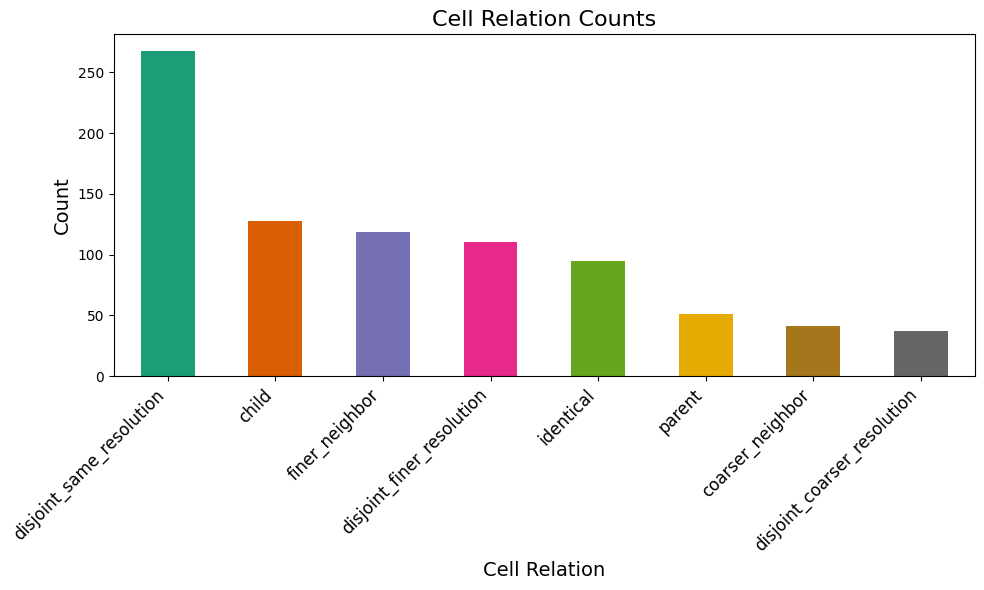

In [53]:
import numpy as np
from pyproj import Transformer
from shapely.ops import transform
from geopy.distance import geodesic
import h3
import shapely.geometry

k = 161  # threshold in km
project = Transformer.from_crs('epsg:4326', 'epsg:6933', always_xy=True).transform

# Prepare DataFrame columns for results (if not present)
for col in ["error_distance", "pred_area_6933", "gt_area_6933", "intersection_area_6933"]:
    if col not in georelated_df.columns:
        georelated_df[col] = np.nan

all_log_q = []
very_off_area_predictions = []

# Calculate all metrics row-wise, store in DataFrame
for index, row in georelated_df.iterrows():
    if row.get('pred_cell') is None or row.get('target_cell') is None:
        continue

    # Parse coordinates
    gt_lat, gt_lon = map(float, map(str.strip, row["target_center"].split(",")))
    gt_coordinates = (gt_lat, gt_lon)
    pred_center = row['georelated']['center coordinates of affected area']
    predicted_coordinates = (pred_center['latitude'], pred_center['longitude'])

    # Geodesic error in km
    error_distance = geodesic(gt_coordinates, predicted_coordinates).kilometers
    georelated_df.at[index, "error_distance"] = error_distance

    # H3 cell shapes
    pred_shape = h3.cells_to_h3shape([row['pred_cell']])
    target_shape = h3.cells_to_h3shape([row['target_cell']])
    pred_poly = shapely.geometry.shape(h3.h3shape_to_geo(pred_shape))
    target_poly = shapely.geometry.shape(h3.h3shape_to_geo(target_shape))

    # Project to equal-area CRS
    pred_poly_proj = transform(project, pred_poly)
    target_poly_proj = transform(project, target_poly)
    pred_area_m2 = pred_poly_proj.area
    gt_area_m2   = target_poly_proj.area

    georelated_df.at[index, "pred_area_6933"] = pred_area_m2
    georelated_df.at[index, "gt_area_6933"] = gt_area_m2

    # Intersection area
    intersection = pred_poly_proj.intersection(target_poly_proj)
    intersection_area = intersection.area
    georelated_df.at[index, "intersection_area_6933"] = intersection_area

    # Calculate proportion metrics for this row (if appropriate)
    try:
        log_q = np.log(pred_area_m2 / gt_area_m2)
        all_log_q.append(log_q)

        normalized_error_diff = (pred_area_m2 - gt_area_m2) / gt_area_m2
        if normalized_error_diff > 10:
            very_off_area_predictions.append(index)
        georelated_df.at[index, "normalized_area_diff"] = normalized_error_diff

        squared_area_diff = (pred_area_m2 - gt_area_m2) ** 2
        georelated_df.at[index, "squared_area_diff"] = squared_area_diff
    except Exception:
        all_log_q.append(np.nan)
        georelated_df.at[index, "normalized_area_diff"] = np.nan
        georelated_df.at[index, "squared_area_diff"] = np.nan

####### Aggregate Metrics ########

# Remove NaNs
all_error_distances = georelated_df["error_distance"].dropna().values
all_log_q = np.array([x for x in all_log_q if not np.isnan(x)])
all_normalized_area_diffs = georelated_df["normalized_area_diff"].dropna().values

# ACCURACY@k
within_k = (all_error_distances <= k)
accuracy_at_k = within_k.mean()
print(f"Accuracy@{k}: {accuracy_at_k:.3f}")

# AUC function as before
def calculate_auc(sorted_values):
    max_error = 20038  # Earth's circumference in km / 2
    size = len(sorted_values)
    if size <= 1:
        return 0.0
    h = 1  # step size
    log_max = np.log(max_error)
    auc = 0.5 * ((np.log(1 + sorted_values[0]) + np.log(1 + sorted_values[-1])) / log_max)
    for v in sorted_values[1:-1]:
        auc += np.log(1 + v) / log_max
    auc = auc * h / (size - 1)
    return auc

sorted_error_distances = np.sort(all_error_distances)
auc = calculate_auc(sorted_error_distances)
print(f"AUC: {auc:.3f}")

# Mean/Median error
mean_error_distance = np.mean(all_error_distances)
median_error_distance = np.median(all_error_distances)
print(f"Mean error distance: {mean_error_distance:.2f}")
print(f"Median error distance: {median_error_distance:.2f}")

# ζ Median Symmetric Accuracy
zeta = 100 * (np.exp(np.median(np.abs(all_log_q))) - 1)
print(f"Median Symmetric Accuracy: {zeta:.2f}")

# SSPB
sspb = 100 * np.sign(np.median(all_log_q)) * (np.exp(np.abs(np.median(all_log_q))) - 1)
print(f"Symmetric Signed Percentage Bias: {sspb:.2f}")

print(f"Number of very off area predictions: {len(very_off_area_predictions)}")

# If you wish to compute average precision/recall/f1, make sure you add those fields to georelated_df
# The following is a sketch, adapt as necessary:
valid = (
    (georelated_df['intersection_area_6933'] > 0) &
    (georelated_df['pred_area_6933'] > 0) &
    (georelated_df['gt_area_6933'] > 0)
)
average_precision = (georelated_df.loc[valid, 'intersection_area_6933'] / georelated_df.loc[valid, 'pred_area_6933']).mean()
average_recall = (georelated_df.loc[valid, 'intersection_area_6933'] / georelated_df.loc[valid, 'gt_area_6933']).mean()
average_f1 = 2 * average_precision * average_recall / (average_precision + average_recall)

print(f"average precision: {average_precision:.3f}, \naverage recall: {average_recall:.3f}, \naverage f1: {average_f1:.3f}")

# Visualize shares of identical, parent, child, coarser neighbor, finer neighbor, disjoint same resolution, disjoint coarser resolution, disjoint finer resolution
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# Define the colors for each category using a colorblind friendly palette
colors = {
    'identical': '#1b9e77',
    'parent': '#d95f02',
    'child': '#7570b3',
    'coarser_neighbor': '#e7298a',
    'finer_neighbor': '#66a61e',
    'disjoint_same_resolution': '#e6ab02',
    'disjoint_coarser_resolution': '#a6761d',
    'disjoint_finer_resolution': '#666666'
}
# Create a color map
cmap = mcolors.ListedColormap(colors.values())
# Create a color normalization
norm = mcolors.BoundaryNorm(boundaries=list(range(len(colors) + 1)), ncolors=len(colors))
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))
# Count occurrences of each cell relation
cell_relation_counts = georelated_df['cell_relation'].value_counts()
# Create a bar plot
cell_relation_counts.plot(kind='bar', color=[cmap(norm(i)) for i in range(len(cell_relation_counts))], ax=ax)
# Set the title and labels
ax.set_title('Cell Relation Counts', fontsize=16)
# rotate x-axis labels
ax.set_xticklabels(cell_relation_counts.index, rotation=45, ha='right', fontsize=12)
ax.set_xlabel('Cell Relation', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
# Show the plot
plt.tight_layout()
plt.show()

In [77]:
from pyproj import Geod

geod = Geod(ellps="WGS84")

def calc_azimuth_distance(row):
    try:
        # Check if coordinates are missing (None or not a dict)
        center = row["georelated"].get("center coordinates of affected area")
        if center is None:
            return pd.Series({'forward_azimuth': None, 'pred_distance': None})
        fwd_azimuth, _, dist = geod.inv(
            row["landmark_longitude"],
            row["landmark_latitude"],
            center["longitude"],
            center["latitude"]
        )
        # Normalize azimuth to 0-360°
        fwd_azimuth = (fwd_azimuth + 360) % 360
        return pd.Series({'forward_azimuth': fwd_azimuth, 'pred_distance': dist})
    except Exception:
        # Catch possible missing keys or bad values
        return pd.Series({'forward_azimuth': None, 'pred_distance': None})

georelated_df[["forward_azimuth", "pred_distance"]] = georelated_df.apply(calc_azimuth_distance, axis=1)
georelated_df

,landmark_id,landmark_name,landmark_latitude,landmark_longitude,landmark_feature_code,landmark_country_code,landmark_population,geospatial_prep,bearing,between_object,...,pred_cell_area,cell_relation,error_distance,pred_area_6933,gt_area_6933,intersection_area_6933,normalized_area_diff,squared_area_diff,forward_azimuth,pred_distance
0,5861897,Fairbanks,64.83778,-147.71639,PPLA2,US,32325,north,0.0,None,...,6.871085e+05,child,1.951730,6.916052e+05,4.840684e+06,6.339904e+05,-0.857127,1.721486e+13,328.222610,3327.867377
1,4893591,Geneva,41.88753,-88.30535,PPLA2,US,21806,northwest,315.0,None,...,3.679660e+07,disjoint_coarser_resolution,443.505724,3.686933e+07,5.207082e+06,0.000000e+00,6.080613,1.002498e+15,300.978576,457898.262952
2,4303602,Paris,38.20980,-84.25299,PPLA2,US,9870,west,270.0,None,...,4.883150e+06,finer_neighbor,8.018337,4.886245e+06,3.423930e+07,0.000000e+00,-0.857291,8.616021e+14,250.736301,22324.607434
3,4691553,Floresville,29.13358,-98.15612,PPLA2,US,7321,south,180.0,None,...,1.212704e+05,child,0.727940,1.211122e+05,5.934238e+06,1.211051e+05,-0.979591,3.379243e+13,230.443297,918.913583
4,5182534,Butler,40.86118,-79.89533,PPLA2,US,13289,south,180.0,None,...,5.201941e+06,child,1.570725,5.208489e+06,3.645941e+07,5.208489e+06,-0.857143,9.766203e+14,233.487923,836.109636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1060,4529292,Altus,34.63813,-99.33398,PPLA2,US,19214,southeast,135.0,None,...,5.782711e+06,finer_neighbor,8.286418,5.781779e+06,4.045220e+07,0.000000e+00,-0.857071,1.202038e+15,215.029637,6316.281827
1061,5045517,Saint Peter,44.32358,-93.95801,PPLA2,US,11196,southeast,135.0,None,...,5.267502e+06,identical,1.810316,5.278386e+06,5.278386e+06,5.278386e+06,0.000000,0.000000e+00,157.180756,1359.824324
1062,4771414,Manassas Park,38.78400,-77.46971,PPLA2,US,15726,northwest,315.0,None,...,3.501155e+07,identical,3.075412,3.503897e+07,3.503897e+07,3.503897e+07,0.000000,0.000000e+00,297.088002,2292.193398
1063,5164466,Newark,40.05812,-82.40126,PPLA2,US,47986,north,0.0,None,...,7.295111e+05,finer_neighbor,2.043949,7.302972e+05,5.114213e+06,0.000000e+00,-0.857202,1.921872e+13,20.349621,1928.025870


In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge
import matplotlib as mpl
from matplotlib.colors import ListedColormap

compass_dirs = {
    'north': (337.5, 22.5),    # [337.5, 22.5)
    'northeast': (22.5, 67.5),
    'east': (67.5, 112.5),
    'southeast': (112.5, 157.5),
    'south': (157.5, 202.5),
    'southwest': (202.5, 247.5),
    'west': (247.5, 292.5),
    'northwest': (292.5, 337.5)
}
# Assign distinct colors (customize as needed)
dir_colors = {
    'north': '#1f77b4',
    'northeast': '#ff7f0e',
    'east': '#2ca02c',
    'southeast': '#d62728',
    'south': '#9467bd',
    'southwest': '#8c564b',
    'west': '#e377c2',
    'northwest': '#7f7f7f'
}
def bearing_to_direction(bearing):
    for direction, (start, end) in compass_dirs.items():
        if start > end:  # handles wrap-around for "north"
            if bearing >= start or bearing < end:
                return direction
        else:
            if start <= bearing < end:
                return direction
    return 'north'

In [84]:
def bin_bearing(bearing):
    return 5 * int(round(bearing / 5))

def bin_distance_ratio(ratio):
    # bins of 5%
    return 0.05 * int(round(ratio / 0.05))

df = georelated_df.copy()
# drop rows with NaN values in the relevant columns
df = df.dropna(subset=["forward_azimuth", "pred_distance", "distance_to_landmark", "bearing"])

# Ensure bearings in [0, 360)
df["forward_azimuth"] = df["forward_azimuth"] % 360
df["bearing"] = df["bearing"] % 360

# Compute normalized distance ratio (pred - gt, relative to gt)
df["distance_rel"] = (df["pred_distance"] - df["distance_to_landmark"]) / df["distance_to_landmark"]  # 0 means perfect match

# Bin bearings and distances
df["bearing_bin"] = df["forward_azimuth"].apply(bin_bearing)
df["distance_bin"] = df["distance_rel"].apply(bin_distance_ratio)

# Annotate with GT compass direction for coloring
df["gt_dir"] = df["bearing"].apply(bearing_to_direction)

# Group for width bins (visual "thickness")
grouped = df.groupby(["bearing_bin", "distance_bin", "gt_dir"]).size().reset_index(name="count")

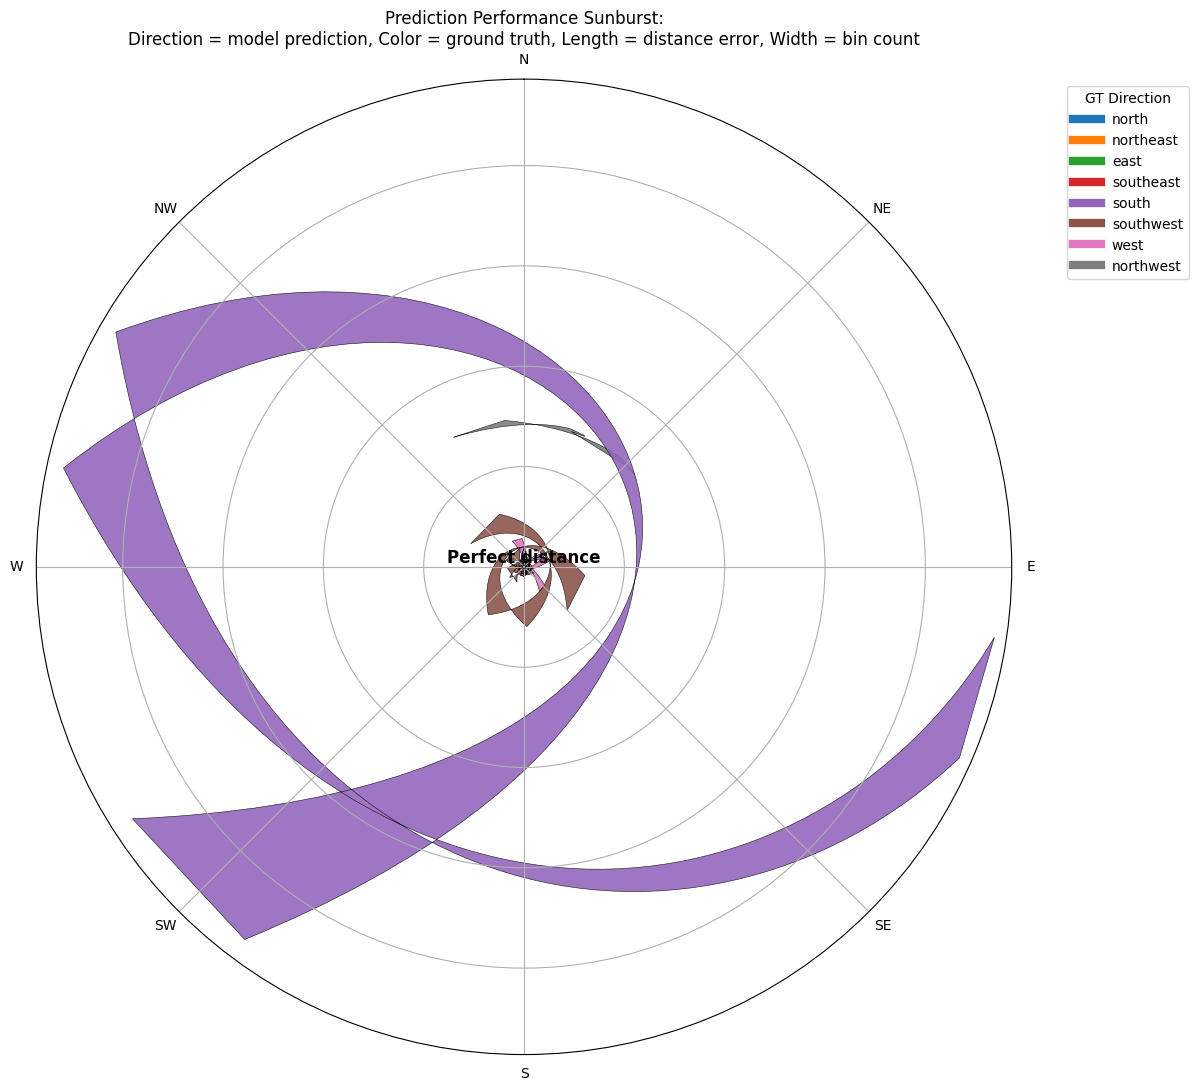

In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge

# --- Setup your processed grouped DataFrame as before (grouped) ---

# --- Parameters ---
ref_radius = 6                 # Middle of plot = zero error
scale_per_bin = 1.5            # Bins per radial (change as needed for aesthetics)
width_per_count = np.deg2rad(4.5)
bar_thickness = 1.2            # Radial extent of each bin

fig, ax = plt.subplots(figsize=(12,12), subplot_kw={'polar': True})
ax.set_theta_direction(-1)
ax.set_theta_offset(np.pi / 2)

for _, row in grouped.iterrows():
    theta = np.deg2rad(row['bearing_bin'])
    # Keep -inward, +outward relative to reference circle
    min_radius = ref_radius + row['distance_bin'] * scale_per_bin
    max_radius = min_radius + bar_thickness
    color = dir_colors.get(row['gt_dir'], 'gray')
    bar_width = width_per_count * row['count']

    # Never draw bars with negative radius!
    if min_radius < 0:
        continue

    bar = Wedge(center=(0,0),
                r=max_radius,
                theta1=np.rad2deg(theta)-np.rad2deg(bar_width/2),
                theta2=np.rad2deg(theta)+np.rad2deg(bar_width/2),
                width=bar_thickness,
                facecolor=color, edgecolor='k', lw=0.4, alpha=0.9)
    ax.add_patch(bar)

# Draw the "correct prediction" reference circle
circ = plt.Circle((0,0), radius=ref_radius, transform=ax.transData._b, color='black', lw=2.5, fill=False, zorder=10, alpha=0.6)
ax.add_artist(circ)
ax.text(0, ref_radius+0.6, 'Perfect distance', ha='center', va='bottom', color='black', fontsize=12, fontweight='bold', zorder=11)

ax.set_ylim(0, ref_radius + grouped['distance_bin'].max() * scale_per_bin + 2)
ax.set_xticks(np.deg2rad(np.arange(0, 360, 45)))
ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])
ax.set_yticklabels([])

# Add legend
handles = [plt.Line2D([0], [0], color=color, lw=6, label=direction) for direction, color in dir_colors.items()]
ax.legend(handles=handles, bbox_to_anchor=(1.05, 1.0), loc='upper left', title="GT Direction")

plt.title("Prediction Performance Sunburst:\nDirection = model prediction, Color = ground truth, Length = distance error, Width = bin count")
plt.tight_layout()
plt.show()

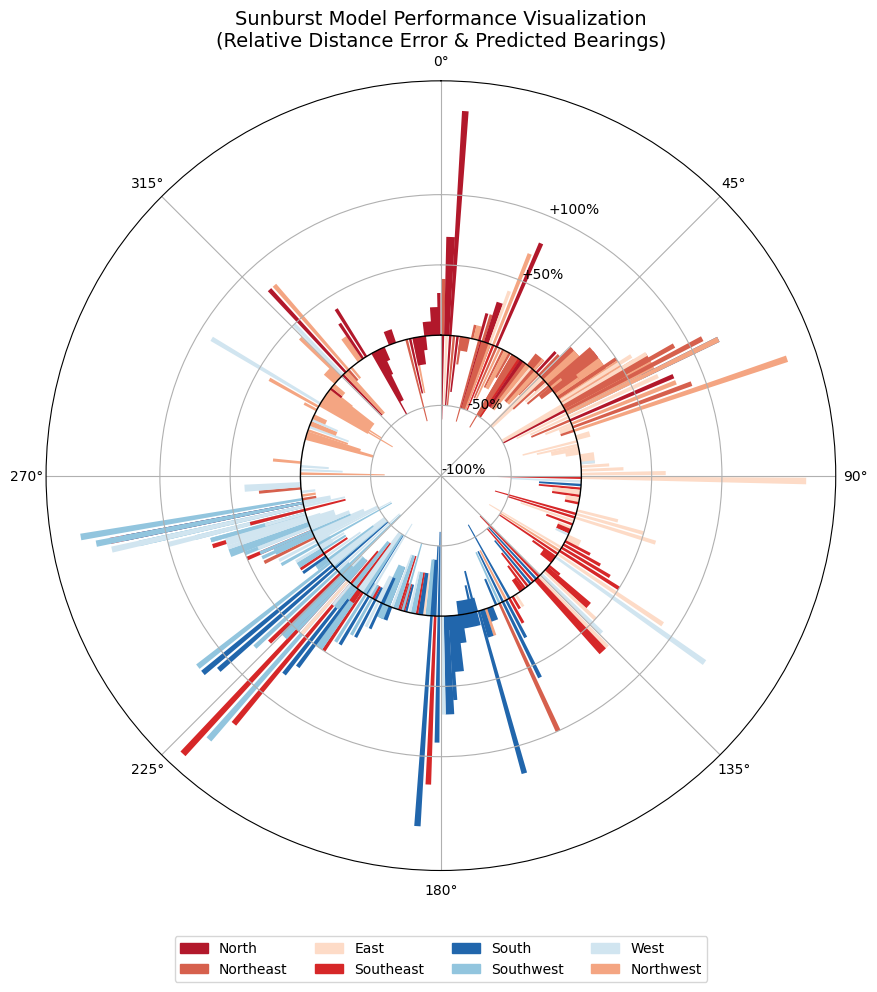

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

df = georelated_df.copy()
# drop rows with NaN values in the relevant columns
df = df.dropna(subset=["forward_azimuth", "pred_distance", "distance_to_landmark", "bearing"])

# Parameters
bearing_bin_size = 15  # degrees
distance_bin_size = 0.1  # % deviation
max_rel_error = 3

# Direction mapping (wraps around for North)
compass_dirs = {
    'north': (337.5, 22.5),
    'northeast': (22.5, 67.5),
    'east': (67.5, 112.5),
    'southeast': (112.5, 157.5),
    'south': (157.5, 202.5),
    'southwest': (202.5, 247.5),
    'west': (247.5, 292.5),
    'northwest': (292.5, 337.5)
}

# Assign colors to directions
dir_colors = {
    'north': '#b2182b',
    'northeast': '#d6604d',
    'east': '#fddbc7',
    'southeast': '#d62728',
    'south': '#2166ac',
    'southwest': '#92c5de',
    'west': '#d1e5f0',
    'northwest': '#f4a582'
}

# Function to map numeric bearing to direction
def bearing_to_direction(bearing):
    for direction, (start, end) in compass_dirs.items():
        if start > end:  # wrap-around for north
            if bearing >= start or bearing < end:
                return direction
        else:
            if start <= bearing < end:
                return direction
    return 'north'

# Preprocessing
# Calculate relative distance error
df['rel_dist_error'] = (df["pred_distance"] - df["distance_to_landmark"]) / df["distance_to_landmark"]

# Use only the 5th to 95th percentile range to exclude extreme outliers
lower_bound = df['rel_dist_error'].quantile(0.1)
upper_bound = df['rel_dist_error'].quantile(0.9)
df = df[(df['rel_dist_error'] >= lower_bound) & (df['rel_dist_error'] <= upper_bound)]


df['bearing_bin'] = (df['forward_azimuth'] // bearing_bin_size * bearing_bin_size).astype(int)
df['dist_bin'] = (df['rel_dist_error'] // distance_bin_size * distance_bin_size).round(2)

df['gt_direction'] = df['bearing'].apply(bearing_to_direction)

# Grouping
grouped = df.groupby(['bearing_bin', 'dist_bin', 'gt_direction']).size().reset_index(name='count')

# Convert to polar coordinates
grouped['theta'] = np.deg2rad(grouped['bearing_bin'])
grouped['r'] = grouped['dist_bin']
grouped['r_transformed'] = grouped['r']

# Offset calculation to avoid overlap
# Assign a unique index per group for radial offset
grouped['bin_idx'] = grouped.groupby('bearing_bin').cumcount()
grouped['theta_offset'] = grouped['bin_idx'] * (bearing_bin_size * np.pi / 180) / 10  # small spread
grouped['theta_final'] = grouped['theta'] + grouped['theta_offset'] - grouped['theta_offset'].mean()

# Normalize width by count
max_count = grouped['count'].max()
grouped['width'] = (grouped['count'] / max_count) * (bearing_bin_size * np.pi / 180) * 0.9

# Plotting
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(10, 10))

# Draw a visible reference line at 0 error
ax.plot(np.linspace(0, 2*np.pi, 100), np.zeros(100), color='black', linewidth=1)

# Draw bars with slight angle spread
for _, row in grouped.iterrows():
    color = dir_colors.get(row['gt_direction'], 'gray')
    ax.bar(
        x=row['theta_final'],
        height=abs(row['r_transformed']),
        width=row['width'],
        bottom=0 if row['r_transformed'] >= 0 else row['r_transformed'],
        color=color,
        alpha=1.0,
        edgecolor='none'
    )

# Style
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_ylim(df['rel_dist_error'].min()-0.1, df['rel_dist_error'].max()+0.1)
ax.set_yticks([-1, -0.5, 0.5, 1])
ax.set_yticklabels(['-100%', '-50%', '+50%', '+100%'])
ax.set_title("Sunburst Model Performance Visualization\n(Relative Distance Error & Predicted Bearings)", fontsize=14)

# Legend
legend_patches = [Patch(color=color, label=dir.title()) for dir, color in dir_colors.items()]
plt.legend(handles=legend_patches, loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=4)

plt.tight_layout()
plt.show()